In [1]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm

In [2]:
class MultiArmedBandits:
    def __init__(self, k = 10, epsilon = 0, initial = 0, true_expected_reward = 0, step_size = None, ucb = None, 
                 gradient = None, baseline = None, thompson = None, bayes_ucb = None, gittins = None, 
                 num_steps = 1000, num_runs = 2000):
        self.k = k
        self.epsilon = epsilon
        self.initial = initial
        self.initial_mu = true_expected_reward
        self.step_size = step_size
        self.ucb_c = ucb # degree of exploration
        self.gradient = gradient # step_size for gradient bandit algorithm
        self.baseline = baseline
        self.thompson = thompson
        self.bayes_ucb_c = bayes_ucb
        self.gi_values = gittins
        self.num_steps = num_steps
        self.num_runs = num_runs
        
        
    def new_bandit(self):
        self.q = np.zeros(self.k) + self.initial
        self.action_count = np.zeros(self.k).astype(int)
        self.mu = np.random.randn(self.k) + self.initial_mu
        self.action_optimal = np.argmax(self.mu)
        self.reward_episode = np.zeros(self.num_steps)
        self.action_episode = np.zeros(self.num_steps)
        if self.gradient:
            self.h = np.zeros(self.k)
            self.prev_rewards_bar = 0
            self.rewards_bar = 0
        if self.thompson or self.bayes_ucb_c:  # flat prior
            self.estimated_mu = np.zeros(self.k)
            self.estimated_var = np.zeros(self.k) + 1
        
            
        
    # default: 1000 steps make up one episode/run    
    def episode(self):
        for step in range(self.num_steps):
            
            # choose action
            if np.random.random() < self.epsilon: # choose randomly
                action = np.random.randint(1,self.k)
            elif self.ucb_c:
                if min(self.action_count) == 0:
                    action = np.argmin(self.action_count)
                else:
                    ucb_action = self.q + self.ucb_c * np.sqrt(np.divide(np.log(step + 1), self.action_count))
                    action = np.argmax(ucb_action)
            elif self.gradient: # gradient bandit: only consider numerical preference
                h_exp = np.exp(self.h)
                pi = h_exp / np.sum(h_exp)
                action = np.random.choice(np.arange(self.k), p = pi)
            elif self.thompson:
                samples = np.random.normal(self.estimated_mu, np.sqrt(self.estimated_var))
                action = np.random.choice(np.where(samples == max(samples))[0])
            elif self.bayes_ucb_c:
                self.q = norm.ppf(1 - 1 / ((step + 1) * pow(np.log(self.num_steps), self.bayes_ucb_c)), 
                                  self.estimated_mu, np.sqrt(self.estimated_var))
                action = np.random.choice(np.where(self.q == max(self.q))[0])
            elif self.gi_values != None:
                gi = self.q + self.gi_values[self.action_count]
                action = np.random.choice(np.where(gi == max(gi))[0])
            else:
                action = np.argmax(self.q)  
            
            
            # update action
            self.action_count[action] += 1
            if action == self.action_optimal:
                self.action_episode[step] = 1

                
            # receive rewards
            reward = np.random.randn() + self.mu[action]
            self.reward_episode[step] = reward
            
            
            # update parameters
            if self.step_size:
                self.q[action] += self.step_size * (reward - self.q[action])  # constant step-size
            elif self.gradient:
                h_action = np.zeros(self.k)
                h_action[action] = 1
                self.h += self.gradient * (reward - self.rewards_bar) * (h_action - pi) # update h, eq. 2.12
                if self.baseline: # if no baseline, q is constantly 0
                    self.rewards_bar += (reward - self.rewards_bar) / (step + 1)           
            elif self.thompson or self.bayes_ucb_c:
                self.estimated_mu[action] += (reward - self.estimated_mu[action]) / self.action_count[action]
                self.estimated_var[action] = 1 / self.action_count[action]
            else: 
                self.q[action] += (reward - self.q[action]) / self.action_count[action]  # sample average
        return self.reward_episode, self.action_episode
    
    # default: average of 2000 runs
    def simulate(self):
        average_reward = np.zeros((self.num_runs, self.num_steps))
        action_percentage = np.zeros((self.num_runs, self.num_steps))
        for run in tqdm(range(self.num_runs)):
            self.new_bandit()
            average_reward[run], action_percentage[run] = self.episode()
        return [np.mean(average_reward, axis = 0), np.mean(action_percentage, axis = 0), np.mean(average_reward, axis = 1)]

In [3]:
bandit_epsilon = MultiArmedBandits(epsilon = 0.1).simulate()
bandit_optimistic_1 = MultiArmedBandits(initial = 1, step_size = 0.1).simulate() # Q1 = 1, epsilon = 0
bandit_ucb_05 = MultiArmedBandits(ucb = 1).simulate() # epsilon = 0, ucb_c = 0.5
bandit_gradient_gradient01_baseline = MultiArmedBandits(true_expected_reward = 0, baseline = True, gradient = 0.1).simulate()
bandit_thompson = MultiArmedBandits(thompson = True).simulate()
bandit_bayes_ucb_5 = MultiArmedBandits(bayes_ucb = 5).simulate()

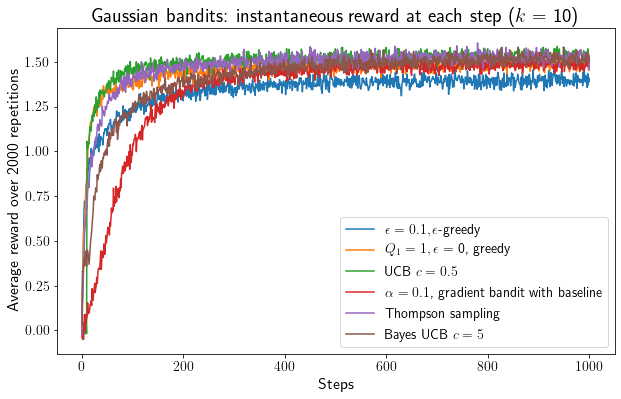

In [8]:
fig = plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(np.arange(1, 1001), bandit_epsilon[0], label=r'$\epsilon = 0.1, \epsilon$-greedy')
plt.plot(np.arange(1, 1001), bandit_optimistic_1[0], label=r'$Q_1 = 1, \epsilon$ = 0, greedy')
plt.plot(np.arange(1, 1001), bandit_ucb_05[0], label=r'UCB $c = 0.5$')
plt.plot(np.arange(1, 1001), bandit_gradient_gradient01_baseline[0], label=r'$\alpha = 0.1$, gradient bandit with baseline')
plt.plot(np.arange(1, 1001), bandit_thompson[0], label=r'Thompson sampling')
plt.plot(np.arange(1, 1001), bandit_bayes_ucb_5[0], label=r'Bayes UCB $c = 5$')
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average reward over 2000 repetitions", fontsize = 16)
plt.title(r"Gaussian bandits: instantaneous reward at each step ($k$ = 10)", fontsize = 20)
plt.legend()

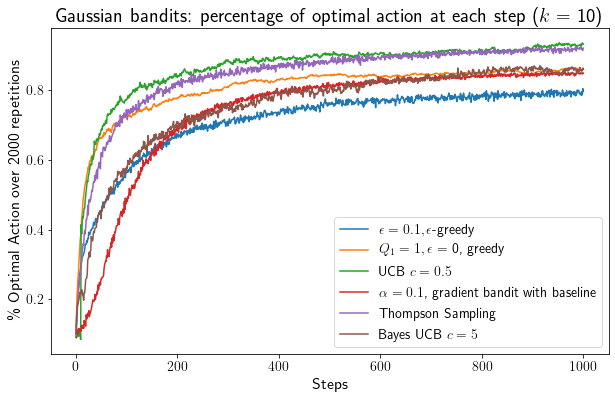

In [9]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.arange(1, 1001), bandit_epsilon[1], label=r'$\epsilon = 0.1, \epsilon$-greedy')
plt.plot(np.arange(1, 1001), bandit_optimistic_1[1], label=r'$Q_1 = 1, \epsilon$ = 0, greedy')
plt.plot(np.arange(1, 1001), bandit_ucb_05[1], label=r'UCB $c = 0.5$')
plt.plot(np.arange(1, 1001), bandit_gradient_gradient01_baseline[1], label=r'$\alpha = 0.1$, gradient bandit with baseline')
plt.plot(np.arange(1, 1001), bandit_thompson[1], label=r'Thompson Sampling')
plt.plot(np.arange(1, 1001), bandit_bayes_ucb_5[1], label=r'Bayes UCB $c = 5$')
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("\% Optimal Action over 2000 repetitions", fontsize = 16)
plt.title(r"Gaussian bandits: percentage of optimal action at each step ($k$ = 10)", fontsize = 20)
plt.legend()

In [29]:
def generate_param(low, high):
    return list(map(lambda x: pow(2, x), np.arange(low, high, dtype=float)))

labels = [r'$\epsilon$-greedy', 'gradient bandit', 'UCB', r'greedy with optimistic intialisation $\alpha$ = 0.1', 'Bayes UCB']
parameters = [generate_param(-7, -1), generate_param(-5, 3), generate_param(-4, 3), generate_param(-2, 3), generate_param(-7, 4)]

# for each parameter and bandit problem, return a single value of the average reward over first 1000 steps
bandits = [lambda eps: MultiArmedBandits(epsilon = eps, num_runs = 10000).simulate()[2],
           lambda alpha: MultiArmedBandits(baseline = True, gradient = alpha, num_runs = 10000).simulate()[2],
           lambda c: MultiArmedBandits(ucb = c, num_runs = 10000).simulate()[2],
           lambda initial: MultiArmedBandits(initial = initial, step_size = 0.1, num_runs = 10000).simulate()[2],
           lambda bayes_c: MultiArmedBandits(bayes_ucb = bayes_c, num_runs = 10000).simulate()[2]]

In [30]:
results = []
for i in range(len(labels)):
    for param in parameters[i]:
        results.append(np.mean(bandits[i](param)))

In [ ]:
total = 0
for i in tqdm(range(1000000)):
    mu = np.random.randn(10)
    total += max(mu)
max_total = total / 1000000

In [21]:
ts = MultiArmedBandits(thompson = True, num_runs = 100000).simulate()[2]
ts_mean = np.mean(ts)
ts_std = np.std(ts)/np.sqrt(100000)
print(ts_mean)
print(ts_std)

1.4601173008792634
0.0018925035648767942


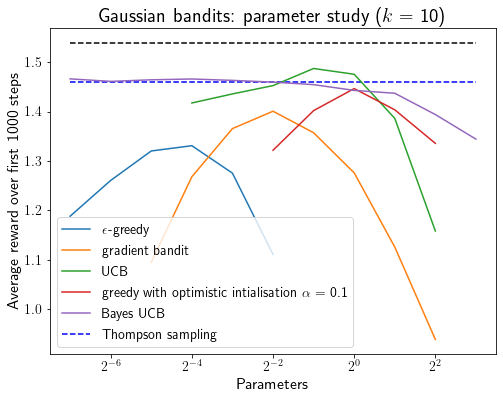

In [46]:
fig, ax = plt.subplots(figsize=(8,6))  
ax.set_xscale('log', basex=2)
i = 0
for label, param in zip(labels, parameters):
    l = len(param)
    plt.plot(param, results_10[i:i+l], label=label)
    i += l
plt.xlabel("Parameters", fontsize = 16)
plt.ylabel("Average reward over first 1000 steps", fontsize = 16)
plt.title(r"Gaussian bandits: parameter study ($k$ = 10)", fontsize = 20)
plt.hlines(y = max_total, xmin = pow(2,-7), xmax = pow(2,3), colors = 'k',linestyle = 'dashed')
plt.hlines(y = ts_mean, xmin = pow(2,-7), xmax = pow(2,3), colors = 'b',linestyle = 'dashed', label = 'Thompson sampling')
plt.legend()

In [47]:
bandit_epsilon_k100 = MultiArmedBandits(k = 100, epsilon = 0.1).simulate()
bandit_optimistic_1_k100 = MultiArmedBandits(k = 100, initial = 1, step_size = 0.1).simulate() # Q1 = 1, epsilon = 0
bandit_ucb_05_k100 = MultiArmedBandits(k = 100, ucb = 0.5).simulate() # epsilon = 0, ucb_c = 0.5
bandit_gradient_gradient01_baseline_k100 = MultiArmedBandits(k = 100, true_expected_reward = 0, baseline = True, gradient = 0.1).simulate()
bandit_thompson_k100 = MultiArmedBandits(k = 100, thompson = True).simulate()
bandit_bayes_ucb_5_k100 = MultiArmedBandits(k = 100, bayes_ucb = 5).simulate()

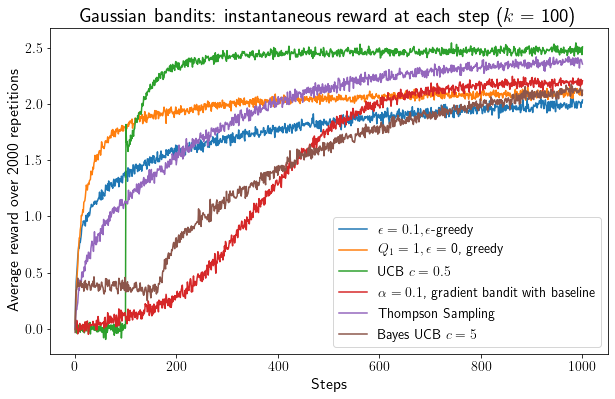

In [48]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.arange(1, 1001), bandit_epsilon_k100[0], label=r'$\epsilon = 0.1, \epsilon$-greedy')
plt.plot(np.arange(1, 1001), bandit_optimistic_1_k100[0], label=r'$Q_1 = 1, \epsilon$ = 0, greedy')
plt.plot(np.arange(1, 1001), bandit_ucb_05_k100[0], label=r'UCB $c = 0.5$')
plt.plot(np.arange(1, 1001), bandit_gradient_gradient01_baseline_k100[0], label=r'$\alpha = 0.1$, gradient bandit with baseline')
plt.plot(np.arange(1, 1001), bandit_thompson_k100[0], label=r'Thompson Sampling')
plt.plot(np.arange(1, 1001), bandit_bayes_ucb_5_k100[0], label=r'Bayes UCB $c = 5$')
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average reward over 2000 repetitions", fontsize = 16)
plt.title(r"Gaussian bandits: instantaneous reward at each step ($k$ = 100)", fontsize = 20)
plt.legend()

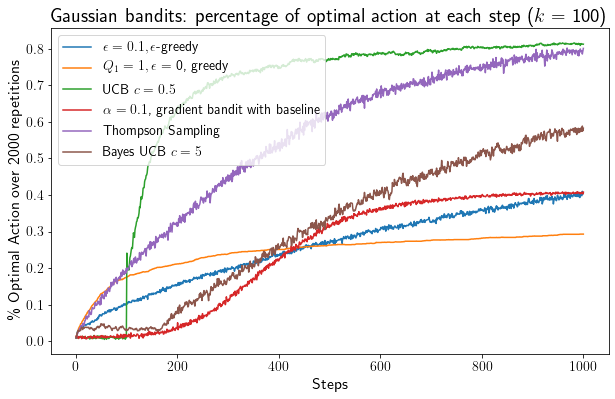

In [49]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.arange(1, 1001), bandit_epsilon_k100[1], label=r'$\epsilon = 0.1, \epsilon$-greedy')
plt.plot(np.arange(1, 1001), bandit_optimistic_1_k100[1], label=r'$Q_1 = 1, \epsilon$ = 0, greedy')
plt.plot(np.arange(1, 1001), bandit_ucb_05_k100[1], label=r'UCB $c = 0.5$')
plt.plot(np.arange(1, 1001), bandit_gradient_gradient01_baseline_k100[1], label=r'$\alpha = 0.1$, gradient bandit with baseline')
plt.plot(np.arange(1, 1001), bandit_thompson_k100[1], label=r'Thompson Sampling')
plt.plot(np.arange(1, 1001), bandit_bayes_ucb_5_k100[1], label=r'Bayes UCB $c = 5$')
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("\% Optimal Action over 2000 repetitions", fontsize = 16)
plt.title(r"Gaussian bandits: percentage of optimal action at each step ($k$ = 100)", fontsize = 20)
plt.legend()

In [15]:
results = []
for i in range(len(labels)):
    for param in parameters[i]:
        results.append(np.mean(bandits[i](param)))

In [ ]:
total = 0
for i in tqdm(range(1000000)):
    mu = np.random.randn(100)
    total += max(mu)
max_total = total / 1000000

In [22]:
ts_100 = MultiArmedBandits(k = 100, thompson = True, num_runs = 100000).simulate()[2]
ts_mean = np.mean(ts_100)
ts_std = np.std(ts_100)/np.sqrt(100000)
print(ts_mean)
print(ts_std)

1.922677866043978
0.0015340449997415313


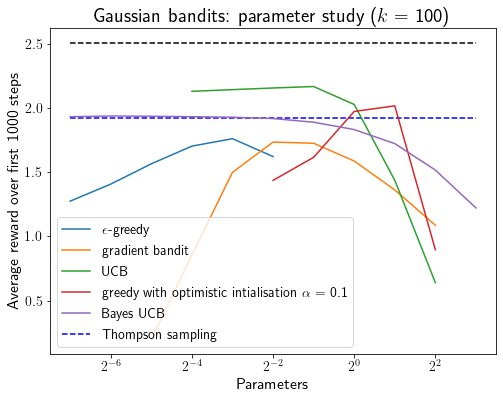

In [42]:
fig, ax = plt.subplots(figsize=(8,6))  
ax.set_xscale('log', basex=2)
i = 0
for label, param in zip(labels, parameters):
    l = len(param)
    plt.plot(param, results_gaussian_k100[i:i+l], label=label)
    i += l
plt.xlabel("Parameters", fontsize = 16)
plt.ylabel("Average reward over first 1000 steps", fontsize = 16)
plt.title(r"Gaussian bandits: parameter study ($k$ = 100)", fontsize = 20)
plt.hlines(y = max_total, xmin = pow(2,-7), xmax = pow(2,3), colors = 'k',linestyle = 'dashed')
plt.hlines(y = ts_mean, xmin = pow(2,-7), xmax = pow(2,3), colors = 'b',linestyle = 'dashed', label = 'Thompson sampling')
plt.legend()
fig.savefig('/Users/yuxin/Desktop/param_study_k100_new.pdf', bbox_inches='tight')